# **Tasks for the final exam**


 **Hakobyan Marta**

1. Continue the task for applications-gen data
    - enricher
        a. Create a day-0 state for a userDevice table (described below)
        b. Create enrich_user_device() function
        to run daily and create a daily state of userDevice table

In [1]:
!git clone https://github.com/ggh96/bdt-ysu-2025.git


Cloning into 'bdt-ysu-2025'...
remote: Enumerating objects: 1231, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 1231 (delta 7), reused 17 (delta 5), pack-reused 1210 (from 2)
Receiving objects: 100% (1231/1231), 164.05 MiB | 14.45 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Updating files: 100% (1204/1204), done.


In [2]:
#Preparing Spark in Colab
!pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window

spark = SparkSession.builder\
    .appName("userDevice")\
    .getOrCreate()

base_path = "/content/bdt-ysu-2025/data/applications-gen/raw"


In [3]:
#Day-0: Code Example
#Reading data for a specific date
from datetime import date

day0 = "2025-12-03"

sessions_df = spark.read.parquet(f"{base_path}/sessions/{day0}")
apps_df     = spark.read.parquet(f"{base_path}/applications/{day0}")
hw_df       = spark.read.parquet(f"{base_path}/hardware/{day0}")
upd_df      = spark.read.parquet(f"{base_path}/updateEvents/{day0}")
users_df    = spark.read.parquet(f"{base_path}/users/{day0}")


In [5]:
from pyspark.sql import functions as F

sessions_df = spark.read.parquet(f"{base_path}/sessions/{day0}")

sessions_df = sessions_df.select(
    F.col("userid").alias("userId"),
    F.col("deviceid").alias("deviceId"),
    "sessionid",
    "clientTs",
    "serverTs",
    "sessionDuration",
    "actions",
    "applicationName",
    "powerMode",
    "batteryPercent",
    "uiSettings"
)


In [9]:
#Day-0 snapshot


base_path = "/content/bdt-ysu-2025/data/applications-gen/raw"
day0 = "2025-12-03"

#  Sessions - registerTs, lastActivityTs, lastSessionTs

sessions_raw = spark.read.parquet(f"{base_path}/sessions/{day0}")

sessions_raw.printSchema()
# # We bring to a single scheme: user Id, device Id, events

sessions = sessions_raw.select(
    F.col("userid").alias("userId"),
    F.col("deviceid").alias("deviceId"),
    F.col("clientTs").alias("eventTs")
)

# registerTs, lastActivityTs, lastSessionTs
user_device_base = (
    sessions
    .groupBy("userId", "deviceId")
    .agg(
        F.min("eventTs").alias("registerTs"),
        F.max("eventTs").alias("lastActivityTs"),
        F.max("eventTs").alias("lastSessionTs")  # last session = last activity by sessions
    )
)


#  applications- applications (map/struct per device)


apps_raw = spark.read.parquet(f"{base_path}/applications/{day0}")

apps_raw.printSchema()


apps = apps_raw.select(
    F.col("deviceid").alias("deviceId"),
    F.col("installedApps").alias("applications")
)


#hardware (array<struct>)


hw_raw = spark.read.parquet(f"{base_path}/hardware/{day0}")

hw_raw.printSchema()


# remove duplicates by device ID
hw_dedup = hw_raw.dropDuplicates(["deviceid"])

hw = (
    hw_dedup
    .select(
        F.col("deviceid").alias("deviceId"),
        F.array(
            F.struct(
                F.col("cpu"),
                F.col("ramGb").alias("ram"),
                F.col("os"),
                F.col("formFactor").alias("deviceType")
            )
        ).alias("hardware")
    )
)


#  userDevice day-0


user_device_day0 = (
    user_device_base
    .join(apps, on="deviceId", how="left")
    .join(hw, on="deviceId", how="left")
    .withColumn("snapshotDate", F.lit(day0))
)

user_device_day0.printSchema()
user_device_day0.show(10, truncate=False)


# save snapshot

user_device_day0.write.mode("overwrite") \
    .partitionBy("snapshotDate") \
    .parquet(f"{base_path}/userDevice")


root
 |-- userid: string (nullable = true)
 |-- deviceid: string (nullable = true)
 |-- sessionid: string (nullable = true)
 |-- clientTs: timestamp (nullable = true)
 |-- serverTs: timestamp (nullable = true)
 |-- sessionDuration: double (nullable = true)
 |-- actions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- action: string (nullable = true)
 |    |    |-- ts: timestamp (nullable = true)
 |-- applicationName: string (nullable = true)
 |-- powerMode: string (nullable = true)
 |-- batteryPercent: integer (nullable = true)
 |-- uiSettings: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)

root
 |-- deviceid: string (nullable = true)
 |-- installedApps: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)

root
 |-- deviceid: string (nullable = true)
 |-- cpu: string (nullable = true)
 |-- ramGb: long (nullable = true)
 |-- os: string (nullable = true)
 |--

In [10]:
#Create enrich_user_device() function
#to run daily and create a daily state of userDevice table

from datetime import datetime, timedelta

base_path = "/content/bdt-ysu-2025/data/applications-gen/raw"

def enrich_user_device(processDate: str):
    # determine yesterday's dat
    d = datetime.strptime(processDate, "%Y-%m-%d")
    prevDate = (d - timedelta(days=1)).strftime("%Y-%m-%d")
    print(f"Enriching snapshot for {processDate}, previous date = {prevDate}")

    #  yesterday's snapshot userDevice
    prev_ud = spark.read.parquet(f"{base_path}/userDevice/snapshotDate={prevDate}")

    prev = prev_ud.select(
        "deviceId",
        "userId",
        F.col("registerTs").alias("registerTs_prev"),
        F.col("lastActivityTs").alias("lastActivityTs_prev"),
        F.col("lastSessionTs").alias("lastSessionTs_prev"),
        F.col("applications").alias("applications_prev"),
        F.col("hardware").alias("hardware_prev")
    )

    # sessions - processDate
    sessions_raw = spark.read.parquet(f"{base_path}/sessions/{processDate}")

    sessions = sessions_raw.select(
        F.col("userid").alias("userId"),
        F.col("deviceid").alias("deviceId"),
        F.col("clientTs").alias("eventTs")
    )

    daily_sessions = (
        sessions
        .groupBy("userId", "deviceId")
        .agg(
            F.min("eventTs").alias("minEventTs"),
            F.max("eventTs").alias("maxEventTs")
        )
        .withColumn("dayLastSessionTs", F.col("maxEventTs"))  # для ясности
    )

    # Connecting yesterday's snapshot and today's session
    joined = prev.join(
        daily_sessions,
        on=["deviceId", "userId"],
        how="full_outer"
    )

    #  restart timestamps
    result = (
        joined
        # registerTs: old if any, otherwise first eventTs today
        .withColumn(
            "registerTs",
            F.when(F.col("registerTs_prev").isNotNull(), F.col("registerTs_prev"))
             .otherwise(F.col("minEventTs"))
        )
        # lastActivityTs: the maximum of the old and the present
        .withColumn(
            "lastActivityTs",
            F.greatest(F.col("lastActivityTs_prev"), F.col("maxEventTs"))
        )
        # lastSessionTs: the maximum of the old and the present
        .withColumn(
            "lastSessionTs",
            F.greatest(F.col("lastSessionTs_prev"), F.col("dayLastSessionTs"))
        )
    )

    # applications - processDate
    apps_raw = spark.read.parquet(f"{base_path}/applications/{processDate}")

    apps_today = apps_raw.select(
        F.col("deviceid").alias("deviceId"),
        F.col("installedApps").alias("applications_today")
    )

    #  hardware - processDate
    hw_raw = spark.read.parquet(f"{base_path}/hardware/{processDate}")
    hw_dedup = hw_raw.dropDuplicates(["deviceid"])

    hw_today = (
        hw_dedup
        .select(
            F.col("deviceid").alias("deviceId"),
            F.array(
                F.struct(
                    F.col("cpu"),
                    F.col("ramGb").alias("ram"),
                    F.col("os"),
                    F.col("formFactor").alias("deviceType")
                )
            ).alias("hardware_today")
        )
    )

    #Pulling up new apps and hardware by deviceId
    result2 = (
        result
        .join(apps_today, on="deviceId", how="left")
        .join(hw_today, on="deviceId", how="left")
    )

    # restart applications и hardware
    result2 = (
        result2
        .withColumn(
            "applications",
            F.when(F.col("applications_today").isNotNull(), F.col("applications_today"))
             .otherwise(F.col("applications_prev"))
        )
        .withColumn(
            "hardware",
            F.when(F.col("hardware_today").isNotNull(), F.col("hardware_today"))
             .otherwise(F.col("hardware_prev"))
        )
    )

    # final snapshot
    final = (
        result2
        .select(
            "deviceId",
            "userId",
            "registerTs",
            "lastActivityTs",
            "lastSessionTs",
            "applications",
            "hardware"
        )
        .withColumn("snapshotDate", F.lit(processDate))
    )

    final.write.mode("append") \
         .partitionBy("snapshotDate") \
         .parquet(f"{base_path}/userDevice")

    print(f"Snapshot for {processDate} written to {base_path}/userDevice")


In [11]:
dates = [
    "2025-12-04",
    "2025-12-05",
    "2025-12-06",
    "2025-12-07",
    "2025-12-08",
    "2025-12-09",
]

for d in dates:
    enrich_user_device(d)


Enriching snapshot for 2025-12-04, previous date = 2025-12-03
Snapshot for 2025-12-04 written to /content/bdt-ysu-2025/data/applications-gen/raw/userDevice
Enriching snapshot for 2025-12-05, previous date = 2025-12-04
Snapshot for 2025-12-05 written to /content/bdt-ysu-2025/data/applications-gen/raw/userDevice
Enriching snapshot for 2025-12-06, previous date = 2025-12-05
Snapshot for 2025-12-06 written to /content/bdt-ysu-2025/data/applications-gen/raw/userDevice
Enriching snapshot for 2025-12-07, previous date = 2025-12-06
Snapshot for 2025-12-07 written to /content/bdt-ysu-2025/data/applications-gen/raw/userDevice
Enriching snapshot for 2025-12-08, previous date = 2025-12-07
Snapshot for 2025-12-08 written to /content/bdt-ysu-2025/data/applications-gen/raw/userDevice
Enriching snapshot for 2025-12-09, previous date = 2025-12-08
Snapshot for 2025-12-09 written to /content/bdt-ysu-2025/data/applications-gen/raw/userDevice


Display userDevice for several dates at once and see how applications and hardware change

In [13]:
dates = ["2025-12-03", "2025-12-04", "2025-12-05"]

ud_some = (
    ud_all
    .filter(F.col("snapshotDate").isin(dates))
)

ud_some.select("deviceId", "userId", "snapshotDate").orderBy("deviceId", "userId", "snapshotDate").show(50, truncate=False)


+---------+---------+------------+
|deviceId |userId   |snapshotDate|
+---------+---------+------------+
|device_0 |user_2266|2025-12-03  |
|device_0 |user_2266|2025-12-04  |
|device_0 |user_2266|2025-12-05  |
|device_0 |user_2401|2025-12-03  |
|device_0 |user_2401|2025-12-04  |
|device_0 |user_2401|2025-12-05  |
|device_0 |user_3365|2025-12-05  |
|device_0 |user_3868|2025-12-05  |
|device_0 |user_4104|2025-12-04  |
|device_0 |user_4104|2025-12-05  |
|device_0 |user_4636|2025-12-05  |
|device_0 |user_4685|2025-12-03  |
|device_0 |user_4685|2025-12-04  |
|device_0 |user_4685|2025-12-05  |
|device_0 |user_4866|2025-12-04  |
|device_0 |user_4866|2025-12-05  |
|device_0 |user_623 |2025-12-05  |
|device_1 |user_1146|2025-12-03  |
|device_1 |user_1146|2025-12-04  |
|device_1 |user_1146|2025-12-05  |
|device_1 |user_1697|2025-12-03  |
|device_1 |user_1697|2025-12-04  |
|device_1 |user_1697|2025-12-05  |
|device_1 |user_2319|2025-12-04  |
|device_1 |user_2319|2025-12-05  |
|device_1 |user_24  

In [14]:
#Tracking by one device/user
target_device = "device_1345"
target_user   = "user_380"

history = (
    ud_all
    .filter(
        (F.col("deviceId") == target_device) &
        (F.col("userId") == target_user)
    )
    .orderBy("snapshotDate")
)

history.select(
    "snapshotDate",
    "applications",
    "hardware"
).show(truncate=False)


+------------+----------------------------------------------------------------------------------------------------------------+------------------------------------+
|snapshotDate|applications                                                                                                    |hardware                            |
+------------+----------------------------------------------------------------------------------------------------------------+------------------------------------+
|2025-12-03  |{IntelliJ -> 3.1, PyCharm -> 4.0, VSCode -> 2.0, Chrome -> 4.0, Discord -> 2.0, Edge -> 3.1}                    |[{Ryzen 7, 8, Windows 10, Desktop}] |
|2025-12-04  |{Illustrator -> 2.0, Steam -> 2.0, VSCode -> 1.0, Chrome -> 3.1, Teams -> 2.0, Photoshop -> 3.1, Firefox -> 4.0}|[{Intel i5, 8, Windows 10, Desktop}]|
|2025-12-05  |{PyCharm -> 1.0, Slack -> 3.1, EpicGames -> 3.1, Outlook -> 2.0, Steam -> 2.0, Teams -> 3.1, Edge -> 2.0}       |[{Intel i5, 16, Linux, Desktop}]    |
|2025-12-0

In [15]:
#Expand hardware into separate columns
history_hw = (
    history
    .withColumn("hw0", F.element_at("hardware", 1))  # 1-й элемент массива
    .select(
        "snapshotDate",
        F.col("hw0.cpu").alias("cpu"),
        F.col("hw0.ram").alias("ram"),
        F.col("hw0.os").alias("os"),
        F.col("hw0.deviceType").alias("deviceType")
    )
    .orderBy("snapshotDate")
)

history_hw.show(truncate=False)


+------------+--------+---+----------+----------+
|snapshotDate|cpu     |ram|os        |deviceType|
+------------+--------+---+----------+----------+
|2025-12-03  |Ryzen 7 |8  |Windows 10|Desktop   |
|2025-12-04  |Intel i5|8  |Windows 10|Desktop   |
|2025-12-05  |Intel i5|16 |Linux     |Desktop   |
|2025-12-06  |Ryzen 7 |32 |Windows 11|Laptop    |
|2025-12-07  |Ryzen 7 |32 |Windows 11|Laptop    |
|2025-12-08  |Ryzen 7 |32 |Windows 11|Laptop    |
|2025-12-09  |Ryzen 7 |32 |Windows 11|Laptop    |
+------------+--------+---+----------+----------+



In [16]:
#how a specific app version changes
history_apps = (
    history
    .select(
        "snapshotDate",
        F.col("applications")["VSCode"].alias("VSCode_version"),
        F.col("applications")["Chrome"].alias("Chrome_version"),
        F.col("applications")["PyCharm"].alias("PyCharm_version")
    )
    .orderBy("snapshotDate")
)

history_apps.show(truncate=False)


+------------+--------------+--------------+---------------+
|snapshotDate|VSCode_version|Chrome_version|PyCharm_version|
+------------+--------------+--------------+---------------+
|2025-12-03  |2.0           |4.0           |4.0            |
|2025-12-04  |1.0           |3.1           |NULL           |
|2025-12-05  |NULL          |NULL          |1.0            |
|2025-12-06  |1.0           |NULL          |NULL           |
|2025-12-07  |1.0           |NULL          |NULL           |
|2025-12-08  |1.0           |NULL          |NULL           |
|2025-12-09  |1.0           |NULL          |NULL           |
+------------+--------------+--------------+---------------+



In [17]:
history_maps = (
    history
    .select(
        "snapshotDate",
        F.map_keys("applications").alias("apps"),
        F.map_values("applications").alias("versions")
    )
    .orderBy("snapshotDate")
)

history_maps.show(truncate=False)


+------------+---------------------------------------------------------------+-----------------------------------+
|snapshotDate|apps                                                           |versions                           |
+------------+---------------------------------------------------------------+-----------------------------------+
|2025-12-03  |[IntelliJ, PyCharm, VSCode, Chrome, Discord, Edge]             |[3.1, 4.0, 2.0, 4.0, 2.0, 3.1]     |
|2025-12-04  |[Illustrator, Steam, VSCode, Chrome, Teams, Photoshop, Firefox]|[2.0, 2.0, 1.0, 3.1, 2.0, 3.1, 4.0]|
|2025-12-05  |[PyCharm, Slack, EpicGames, Outlook, Steam, Teams, Edge]       |[1.0, 3.1, 3.1, 2.0, 2.0, 3.1, 2.0]|
|2025-12-06  |[IntelliJ, VSCode, Slack, Illustrator, Steam]                  |[4.0, 1.0, 4.0, 2.0, 2.0]          |
|2025-12-07  |[IntelliJ, VSCode, Slack, Illustrator, Steam]                  |[4.0, 1.0, 4.0, 2.0, 2.0]          |
|2025-12-08  |[IntelliJ, VSCode, Slack, Illustrator, Steam]                  |[4

       ** Create functions for daily aggregations**
            a. aggregate_total_n_of_users_so_far_daily() # a cumulative number showing nOfUsers that join us so far
           

In [18]:
from pyspark.sql import functions as F, Window

base_path = "/content/bdt-ysu-2025/data/applications-gen/raw"

def aggregate_total_n_of_users_so_far_daily():
    # all sessions
    sessions_raw = spark.read.parquet(f"{base_path}/sessions/*")

    sessions = sessions_raw.select(
        F.col("userid").alias("userId"),
        F.to_date(F.col("clientTs")).alias("eventDate")
    ).dropna(subset=["userId", "eventDate"])

    # first date
    user_first_date = (
        sessions
        .groupBy("userId")
        .agg(F.min("eventDate").alias("firstDate"))
    )

    # new users by date
    new_users_by_date = (
        user_first_date
        .groupBy("firstDate")
        .agg(F.count("*").alias("newUsers"))
        .withColumnRenamed("firstDate", "eventDate")
    )


    w = Window.orderBy("eventDate").rowsBetween(Window.unboundedPreceding, Window.currentRow)

    result = (
        new_users_by_date
        .withColumn("totalUsersSoFar", F.sum("newUsers").over(w))
        .orderBy("eventDate")
    )

    # save
    out_path = f"{base_path}/aggregates/total_users_daily"
    result.write.mode("overwrite").parquet(out_path)

    print(f"Written daily total users aggregate to {out_path}")
    return result


In [19]:
total_users_df = aggregate_total_n_of_users_so_far_daily()
total_users_df.show(20, truncate=False)


Written daily total users aggregate to /content/bdt-ysu-2025/data/applications-gen/raw/aggregates/total_users_daily
+----------+--------+---------------+
|eventDate |newUsers|totalUsersSoFar|
+----------+--------+---------------+
|2025-12-02|2492    |2492           |
|2025-12-03|2463    |4955           |
|2025-12-04|45      |5000           |
+----------+--------+---------------+



     Create functions for daily aggregations
           
            b. aggregate_n_of_installs_uninstalls_daily() # daily number of install and uninstall events

In [27]:

base_path = "/content/bdt-ysu-2025/data/applications-gen/raw"

def aggregate_n_of_installs_uninstalls_daily():
    # all updateEvents
    upd_raw = spark.read.parquet(f"{base_path}/updateEvents/*")

    upd_raw.printSchema()

    events = (
        upd_raw
        .select(
            F.to_date(F.col("eventTs")).alias("eventDate"),
            F.col("eventType")
        )
        .dropna(subset=["eventDate", "eventType"])
    )

    # events
    agg = (
        events
        .groupBy("eventDate", "eventType")
        .agg(F.count("*").alias("nEvents"))
    )

    pivoted = (
        agg
        .groupBy("eventDate")
        .pivot("eventType", ["optimized", "updated", "killed"])
        .agg(F.first("nEvents"))
        .fillna(0)
        .orderBy("eventDate")
    )

    #  install / uninstall
    result = (
        pivoted
        .withColumn("nInstalls",   F.col("optimized") + F.col("updated"))
        .withColumn("nUninstalls", F.col("killed"))
        .select(
            "eventDate",
            "nInstalls",
            "nUninstalls",
            "optimized",
            "updated",
            "killed"
        )
        .orderBy("eventDate")
    )

    # save
    out_path = f"{base_path}/aggregates/installs_uninstalls_daily"
    result.write.mode("overwrite").parquet(out_path)

    print(f"Written daily install/uninstall aggregate to {out_path}")
    return result


In [28]:
inst_uninst_df = aggregate_n_of_installs_uninstalls_daily()
inst_uninst_df.show(20, truncate=False)


root
 |-- deviceid: string (nullable = true)
 |-- application: string (nullable = true)
 |-- eventType: string (nullable = true)
 |-- eventTs: timestamp (nullable = true)

Written daily install/uninstall aggregate to /content/bdt-ysu-2025/data/applications-gen/raw/aggregates/installs_uninstalls_daily
+----------+---------+-----------+---------+-------+------+
|eventDate |nInstalls|nUninstalls|optimized|updated|killed|
+----------+---------+-----------+---------+-------+------+
|2025-12-02|1127     |587        |550      |577    |587   |
|2025-12-03|6945     |3535       |3475     |3470   |3535  |
|2025-12-04|6940     |3444       |3461     |3479   |3444  |
|2025-12-05|6887     |3507       |3435     |3452   |3507  |
|2025-12-06|7081     |3484       |3576     |3505   |3484  |
|2025-12-07|7032     |3419       |3549     |3483   |3419  |
|2025-12-08|6965     |3417       |3505     |3460   |3417  |
|2025-12-09|5733     |2973       |2858     |2875   |2973  |
+----------+---------+-----------+----

 Create at least 3 LOGICAL on different raw datasets, wrap with a function that also reports the found issues

In [29]:


base_path = "/content/bdt-ysu-2025/data/applications-gen/raw"

def dq_sessions(processDate: str):
    df = spark.read.parquet(f"{base_path}/sessions/{processDate}")

    checks = []

    # all rows
    total = df.count()
    checks.append(("sessions", "total_rows", total))

    #  userid/deviceid
    null_ids = df.filter(F.col("userid").isNull() | F.col("deviceid").isNull()).count()
    checks.append(("sessions", "null_user_or_device", null_ids))

    # negative duration
    negative_duration = df.filter(F.col("sessionDuration") < 0).count()
    checks.append(("sessions", "negative_session_duration", negative_duration))

    #  clientTs > serverTs
    inconsistent_ts = df.filter(F.col("clientTs") > F.col("serverTs")).count()
    checks.append(("sessions", "client_after_server_ts", inconsistent_ts))

    # dub (userid, deviceid, sessionid)
    dup_sessions = (
        df.groupBy("userid", "deviceid", "sessionid")
          .count()
          .filter(F.col("count") > 1)
          .count()
    )
    checks.append(("sessions", "duplicate_sessions", dup_sessions))

    return spark.createDataFrame(checks, ["dataset", "check_name", "n_issues"])


In [30]:
def dq_applications(processDate: str):
    df = spark.read.parquet(f"{base_path}/applications/{processDate}")

    checks = []

    total = df.count()
    checks.append(("applications", "total_rows", total))

    #  installedApps is null
    null_apps = df.filter(F.col("installedApps").isNull()).count()
    checks.append(("applications", "null_installedApps", null_apps))

    # installedApps  map
    empty_apps = df.filter(F.size("installedApps") == 0).count()
    checks.append(("applications", "empty_installedApps", empty_apps))

    # too many apps
    too_many_apps = df.filter(F.size("installedApps") > 100).count()
    checks.append(("applications", "too_many_apps_over_100", too_many_apps))

    return spark.createDataFrame(checks, ["dataset", "check_name", "n_issues"])


In [31]:
def dq_hardware(processDate: str):
    df = spark.read.parquet(f"{base_path}/hardware/{processDate}")

    checks = []

    total = df.count()
    checks.append(("hardware", "total_rows", total))

    #  null
    null_hw = df.filter(
        F.col("cpu").isNull() |
        F.col("ramGb").isNull() |
        F.col("os").isNull() |
        F.col("formFactor").isNull()
    ).count()
    checks.append(("hardware", "null_hw_fields", null_hw))

    bad_ram = df.filter((F.col("ramGb") <= 0) | (F.col("ramGb") > 1024)).count()
    checks.append(("hardware", "invalid_ramGb", bad_ram))

    conflicting_hw = (
        df.groupBy("deviceid")
          .agg(
              F.countDistinct(
                  F.struct("cpu", "ramGb", "os", "formFactor")
              ).alias("n_variants")
          )
          .filter(F.col("n_variants") > 1)
          .count()
    )
    checks.append(("hardware", "conflicting_hw_for_same_device", conflicting_hw))

    return spark.createDataFrame(checks, ["dataset", "check_name", "n_issues"])


In [32]:
def run_data_quality_checks(processDate: str):
    dq_s = dq_sessions(processDate)
    dq_a = dq_applications(processDate)
    dq_h = dq_hardware(processDate)

    report = dq_s.union(dq_a).union(dq_h)

    print(f"=== Data Quality Report for {processDate} ===")
    report.show(truncate=False)

    return report


In [33]:
dq_report = run_data_quality_checks("2025-12-03")


=== Data Quality Report for 2025-12-03 ===
+------------+------------------------------+--------+
|dataset     |check_name                    |n_issues|
+------------+------------------------------+--------+
|sessions    |total_rows                    |20000   |
|sessions    |null_user_or_device           |0       |
|sessions    |negative_session_duration     |5085    |
|sessions    |client_after_server_ts        |5085    |
|sessions    |duplicate_sessions            |0       |
|applications|total_rows                    |3500    |
|applications|null_installedApps            |0       |
|applications|empty_installedApps           |0       |
|applications|too_many_apps_over_100        |0       |
|hardware    |total_rows                    |3500    |
|hardware    |null_hw_fields                |0       |
|hardware    |invalid_ramGb                 |0       |
|hardware    |conflicting_hw_for_same_device|0       |
+------------+------------------------------+--------+



# 2. Analyze final/meta-Montana.json

 a. EDA - most popular categories, highest rated categories, etc, + VISUALIZE

In [35]:
import json
import pandas as pd

path = "/content/bdt-ysu-2025/data/final/meta-Montana.json"

rows = []
with open(path, "r") as f:
    for line in f:
        line = line.strip()
        if line:                  # skip empty lines
            rows.append(json.loads(line))

df = pd.DataFrame(rows)

df.head()


,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,"Big Sky Truck & Equipment, Inc.","Big Sky Truck & Equipment, Inc., 6494 U.S. Hig...",0x535dc557d042b1f3:0xc419b6f55435c7de,None,46.933522,-114.106515,"[Truck accessories store, Diesel engine dealer...",3.0,2,None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu...","{'Service options': ['In-store pickup', 'In-st...",Open ⋅ Closes 5PM,"[0x535dcbcf35d19b91:0xa0d0e7f0f42a94b6, 0x535d...",https://www.google.com/maps/place//data=!4m2!3...
1,Wheelbarrow Creek Ranch,"Wheelbarrow Creek Ranch, 1506 Wheelbarrow Cree...",0x535c2690c357f3bd:0x272620bb52fecf11,None,46.582787,-113.950324,[Ranch],5.0,2,None,None,None,Open now,"[0x535e993bd79abfed:0xef2dffa2c4d450b1, 0x535e...",https://www.google.com/maps/place//data=!4m2!3...
2,Montana Saws,"Montana Saws, 3779 Eastside Hwy, Stevensville,...",0x535e9ec3ce050deb:0x2169887374ce879f,None,46.499112,-114.093649,"[Small engine repair service, Garden center]",4.7,28,None,"[[Thursday, 9AM–6PM], [Friday, 9AM–6PM], [Satu...",{'Accessibility': ['Wheelchair accessible entr...,Open ⋅ Closes 6PM,"[0x535ea2b8fc78a29d:0x4afec6e772204072, 0x535e...",https://www.google.com/maps/place//data=!4m2!3...
3,Regis Salon,"Regis Salon, 2901 Brooks St Ste B-12, Missoula...",0x535dcd8d0868cfd1:0xa4bcdf67cf1f3a76,None,46.846230,-114.026820,"[Hair salon, Barber shop, Beauty salon, Hairdr...",3.3,38,None,"[[Thursday, 10AM–9PM], [Friday, 10AM–9PM], [Sa...",{'Accessibility': ['Wheelchair accessible entr...,Permanently closed,"[0x535dcdf32d35aa99:0x759cd7bfffe9b23a, 0x535d...",https://www.google.com/maps/place//data=!4m2!3...
4,Ferguson Plumbing Supply,"Ferguson Plumbing Supply, 3843 Brooks St, Miss...",0x56c663acaebf110b:0x117445f25e7e988a,"Wholesale distributor of plumbing, HVAC, water...",46.836223,-114.041582,"[Plumbing supply store, Bathroom supply store,...",4.6,5,$$,"[[Thursday, 7AM–5PM], [Friday, 7AM–5PM], [Satu...","{'Service options': ['Curbside pickup', 'Deliv...",Open ⋅ Closes 5PM,"[0x535dcde9d8e76fe1:0xe0b24cd42cf705d7, 0x535d...",https://www.google.com/maps/place//data=!4m2!3...


In [38]:
df.info()
df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21680 entries, 0 to 21679
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              21680 non-null  object 
 1   address           21371 non-null  object 
 2   gmap_id           21680 non-null  object 
 3   description       2607 non-null   object 
 4   latitude          21680 non-null  float64
 5   longitude         21680 non-null  float64
 6   category          21590 non-null  object 
 7   avg_rating        21680 non-null  float64
 8   num_of_reviews    21680 non-null  int64  
 9   price             3001 non-null   object 
 10  hours             14984 non-null  object 
 11  MISC              16651 non-null  object 
 12  state             13968 non-null  object 
 13  relative_results  18926 non-null  object 
 14  url               21680 non-null  object 
dtypes: float64(3), int64(1), object(11)
memory usage: 2.5+ MB


,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
count,21680,21371,21680,2607,21680.000000,21680.000000,21590,21680.000000,21680.000000,3001,14984,16651,13968,18926,21680
unique,18421,21169,21534,1387,NaN,NaN,6821,NaN,NaN,6,7660,5901,559,18747,21534
top,Conoco,"Rock Creek, Montana",0x535b90cf0f3fbc0d:0x6dc4aabd36275cf0,Casual counter-serve chain for build-your-own ...,NaN,NaN,[Campground],NaN,NaN,$$,"[[Saturday, Closed], [Sunday, Closed], [Monday...",{'Accessibility': ['Wheelchair accessible entr...,Open 24 hours,[0x53688df3dee630c5:0x804171101ee6c8ab],https://www.google.com/maps/place//data=!4m2!3...
freq,132,4,2,83,NaN,NaN,389,NaN,NaN,1503,197,4023,933,4,2
mean,NaN,NaN,NaN,NaN,46.699219,-111.588271,NaN,4.382417,89.203828,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,1.055297,2.540371,NaN,0.597772,210.326785,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,30.407180,-122.601452,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,45.773883,-114.028596,NaN,4.100000,7.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,46.593247,-111.856159,NaN,4.500000,24.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,47.510949,-109.954550,NaN,4.800000,78.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
df_exploded = df.explode("category")
df_exploded.head()


,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,"Big Sky Truck & Equipment, Inc.","Big Sky Truck & Equipment, Inc., 6494 U.S. Hig...",0x535dc557d042b1f3:0xc419b6f55435c7de,None,46.933522,-114.106515,Truck accessories store,3.0,2,None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu...","{'Service options': ['In-store pickup', 'In-st...",Open ⋅ Closes 5PM,"[0x535dcbcf35d19b91:0xa0d0e7f0f42a94b6, 0x535d...",https://www.google.com/maps/place//data=!4m2!3...
0,"Big Sky Truck & Equipment, Inc.","Big Sky Truck & Equipment, Inc., 6494 U.S. Hig...",0x535dc557d042b1f3:0xc419b6f55435c7de,None,46.933522,-114.106515,Diesel engine dealer,3.0,2,None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu...","{'Service options': ['In-store pickup', 'In-st...",Open ⋅ Closes 5PM,"[0x535dcbcf35d19b91:0xa0d0e7f0f42a94b6, 0x535d...",https://www.google.com/maps/place//data=!4m2!3...
0,"Big Sky Truck & Equipment, Inc.","Big Sky Truck & Equipment, Inc., 6494 U.S. Hig...",0x535dc557d042b1f3:0xc419b6f55435c7de,None,46.933522,-114.106515,Used auto parts store,3.0,2,None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu...","{'Service options': ['In-store pickup', 'In-st...",Open ⋅ Closes 5PM,"[0x535dcbcf35d19b91:0xa0d0e7f0f42a94b6, 0x535d...",https://www.google.com/maps/place//data=!4m2!3...
1,Wheelbarrow Creek Ranch,"Wheelbarrow Creek Ranch, 1506 Wheelbarrow Cree...",0x535c2690c357f3bd:0x272620bb52fecf11,None,46.582787,-113.950324,Ranch,5.0,2,None,None,None,Open now,"[0x535e993bd79abfed:0xef2dffa2c4d450b1, 0x535e...",https://www.google.com/maps/place//data=!4m2!3...
2,Montana Saws,"Montana Saws, 3779 Eastside Hwy, Stevensville,...",0x535e9ec3ce050deb:0x2169887374ce879f,None,46.499112,-114.093649,Small engine repair service,4.7,28,None,"[[Thursday, 9AM–6PM], [Friday, 9AM–6PM], [Satu...",{'Accessibility': ['Wheelchair accessible entr...,Open ⋅ Closes 6PM,"[0x535ea2b8fc78a29d:0x4afec6e772204072, 0x535e...",https://www.google.com/maps/place//data=!4m2!3...


 VISUALIZE

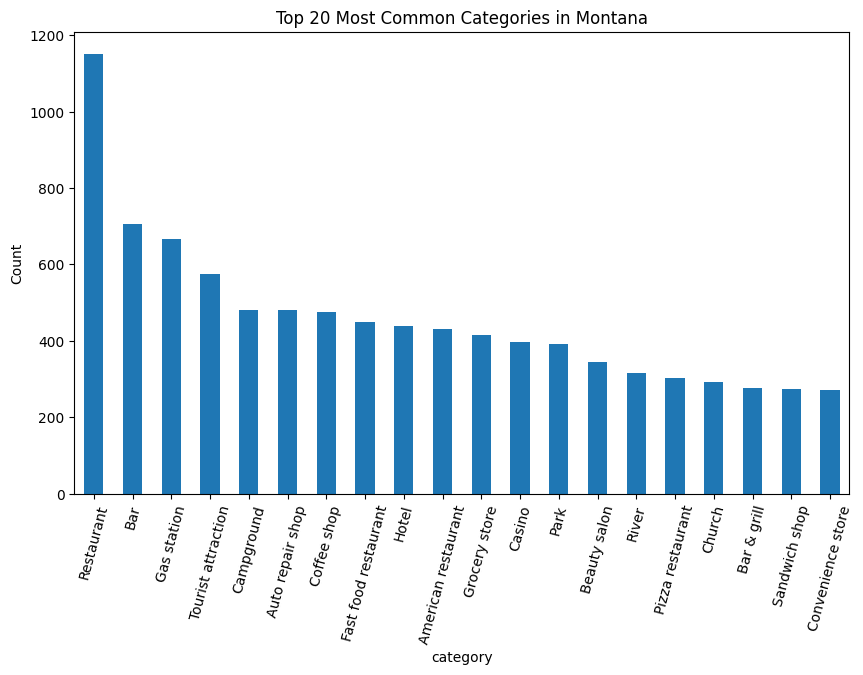

In [40]:
import matplotlib.pyplot as plt

top_categories = df_exploded["category"].value_counts().head(20)

plt.figure(figsize=(10,6))
top_categories.plot(kind="bar")
plt.title("Top 20 Most Common Categories in Montana")
plt.ylabel("Count")
plt.xticks(rotation=75)
plt.show()


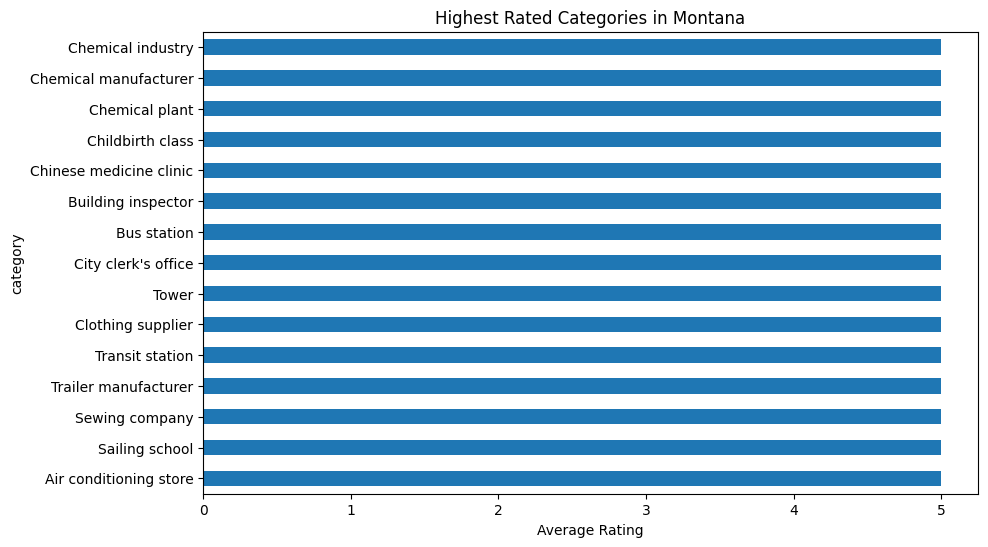

In [41]:
cat_rating = (
    df_exploded.groupby("category")["avg_rating"]
    .mean()
    .sort_values(ascending=False)
)

top_rated = cat_rating.head(15)

plt.figure(figsize=(10,6))
top_rated.plot(kind="barh")
plt.title("Highest Rated Categories in Montana")
plt.xlabel("Average Rating")
plt.gca().invert_yaxis()
plt.show()


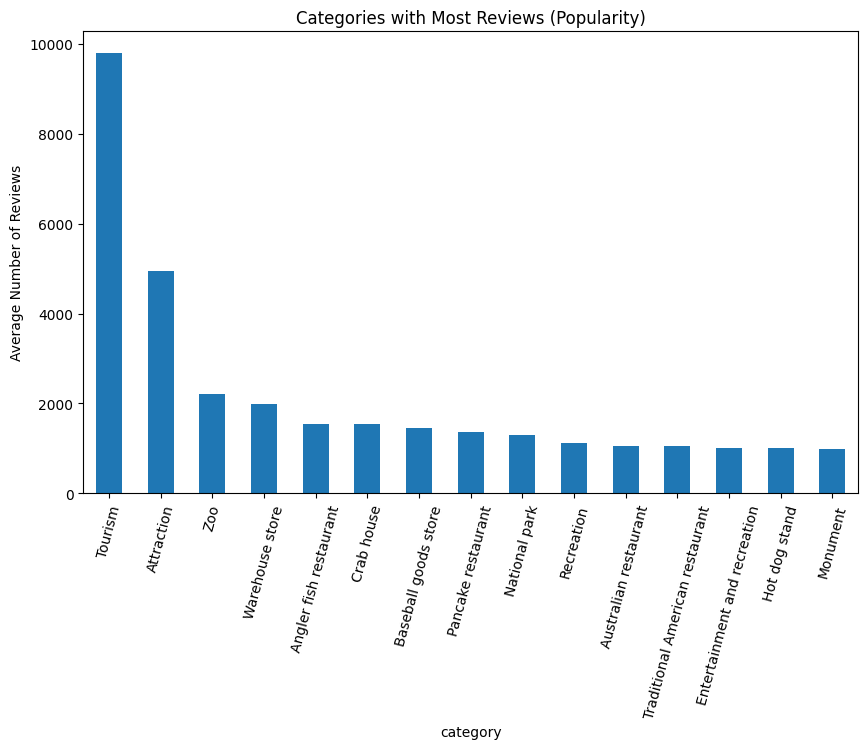

In [42]:
cat_reviews = (
    df_exploded.groupby("category")["num_of_reviews"]
    .mean()
    .sort_values(ascending=False)
)

top_reviews = cat_reviews.head(15)

plt.figure(figsize=(10,6))
top_reviews.plot(kind="bar")
plt.title("Categories with Most Reviews (Popularity)")
plt.ylabel("Average Number of Reviews")
plt.xticks(rotation=75)
plt.show()


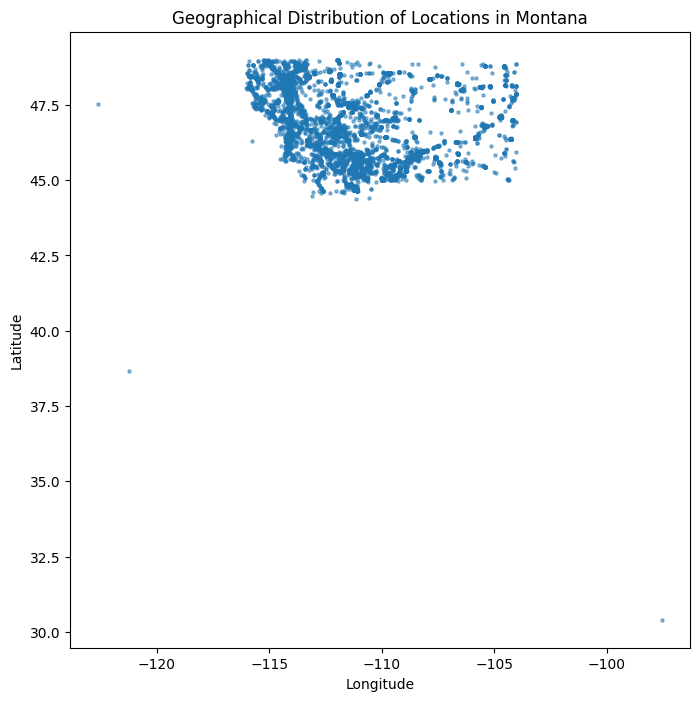

In [44]:
plt.figure(figsize=(8,8))
plt.scatter(df["longitude"], df["latitude"], s=5, alpha=0.5)
plt.title("Geographical Distribution of Locations in Montana")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [46]:
top_categories.head(20)
top_rated
top_reviews


,num_of_reviews
category,
Tourism,9788.000000
Attraction,4956.500000
Zoo,2218.500000
Warehouse store,1977.833333
Angler fish restaurant,1538.000000
Crab house,1538.000000
Baseball goods store,1453.000000
Pancake restaurant,1362.500000
National park,1288.363636


b. Analyze the nightlife (9pm to 6am) | weekends vs weekdays | VISUALIZE

In [57]:
def parse_hours_row(hours):
#change format
    parsed = []

    if not isinstance(hours, list):
        return parsed

    for item in hours:
        # item = ['Thursday', '8AM–5PM'] or ['Saturday', 'Closed']
        if not isinstance(item, (list, tuple)) or len(item) < 2:
            continue

        day = str(item[0]).strip()
        times = str(item[1]).strip()

        # skip closed days
        if times.lower() in ("closed", "temporarily closed"):
            continue

        # norm -
        times = times.replace("–", "-")

        # format '8AM-5PM'
        if "-" not in times:
            continue

        open_str, close_str = [t.strip() for t in times.split("-", 1)]

        parsed.append((day, open_str, close_str))

    return parsed


In [58]:
df["parsed_hours"] = df["hours"].apply(parse_hours_row)
df[["hours", "parsed_hours"]].head(10)


,hours,parsed_hours
0,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu...","[(Thursday, 8AM, 5PM), (Friday, 8AM, 5PM), (Mo..."
1,None,[]
2,"[[Thursday, 9AM–6PM], [Friday, 9AM–6PM], [Satu...","[(Thursday, 9AM, 6PM), (Friday, 9AM, 6PM), (Sa..."
3,"[[Thursday, 10AM–9PM], [Friday, 10AM–9PM], [Sa...","[(Thursday, 10AM, 9PM), (Friday, 10AM, 9PM), (..."
4,"[[Thursday, 7AM–5PM], [Friday, 7AM–5PM], [Satu...","[(Thursday, 7AM, 5PM), (Friday, 7AM, 5PM), (Mo..."
5,"[[Thursday, 9AM–9PM], [Friday, 9AM–9PM], [Satu...","[(Thursday, 9AM, 9PM), (Friday, 9AM, 9PM), (Sa..."
6,"[[Thursday, 12–9PM], [Friday, 12–10PM], [Satur...","[(Thursday, 12, 9PM), (Friday, 12, 10PM), (Sat..."
7,None,[]
8,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu...","[(Thursday, 8AM, 5PM), (Friday, 8AM, 5PM), (Mo..."
9,None,[]


In [63]:
def is_night_row(row):
    o = parse_hour_to_int(row["open_str"])
    c = parse_hour_to_int(row["close_str"])

    if o is None or c is None:
        return False

    #  21:00 – 06:00
    if c >= 21:      #
        return True
    if o < 6:
        return True


    if o == 0 and c == 0:
        return True

    return False


In [64]:
hours_long["is_night"] = hours_long.apply(is_night_row, axis=1)
night_rows = hours_long[hours_long["is_night"] == True]

print("night_rows shape:", night_rows.shape)
night_rows.head()


night_rows shape: (14993, 10)


,gmap_id,category,avg_rating,num_of_reviews,parsed_hours,day,open_str,close_str,is_night,is_weekend
3,0x535dcd8d0868cfd1:0xa4bcdf67cf1f3a76,"[Hair salon, Barber shop, Beauty salon, Hairdr...",3.3,38,"(Thursday, 10AM, 9PM)",Thursday,10AM,9PM,True,False
3,0x535dcd8d0868cfd1:0xa4bcdf67cf1f3a76,"[Hair salon, Barber shop, Beauty salon, Hairdr...",3.3,38,"(Friday, 10AM, 9PM)",Friday,10AM,9PM,True,True
3,0x535dcd8d0868cfd1:0xa4bcdf67cf1f3a76,"[Hair salon, Barber shop, Beauty salon, Hairdr...",3.3,38,"(Saturday, 10AM, 9PM)",Saturday,10AM,9PM,True,True
3,0x535dcd8d0868cfd1:0xa4bcdf67cf1f3a76,"[Hair salon, Barber shop, Beauty salon, Hairdr...",3.3,38,"(Monday, 10AM, 9PM)",Monday,10AM,9PM,True,False
3,0x535dcd8d0868cfd1:0xa4bcdf67cf1f3a76,"[Hair salon, Barber shop, Beauty salon, Hairdr...",3.3,38,"(Tuesday, 10AM, 9PM)",Tuesday,10AM,9PM,True,False


VISUALIZE

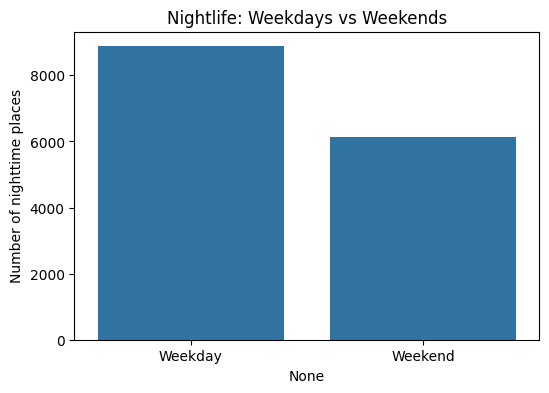

In [65]:
counts = night_rows.groupby("is_weekend").size()
counts.index = ["Weekday", "Weekend"]

plt.figure(figsize=(6,4))
sns.barplot(x=counts.index, y=counts.values)
plt.title("Nightlife: Weekdays vs Weekends")
plt.ylabel("Number of nighttime places")
plt.show()


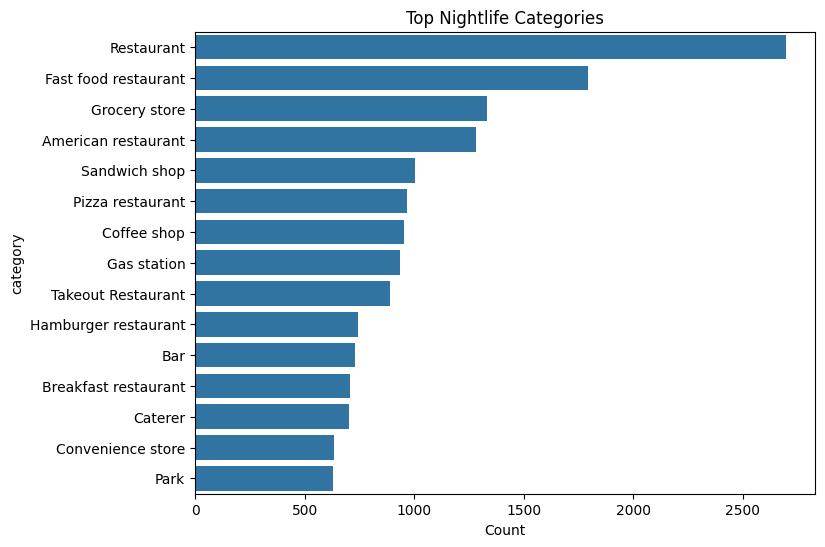

In [66]:
categories = night_rows.explode("category")
top_cat = categories["category"].value_counts().head(15)

plt.figure(figsize=(8,6))
sns.barplot(y=top_cat.index, x=top_cat.values)
plt.title("Top Nightlife Categories")
plt.xlabel("Count")
plt.show()


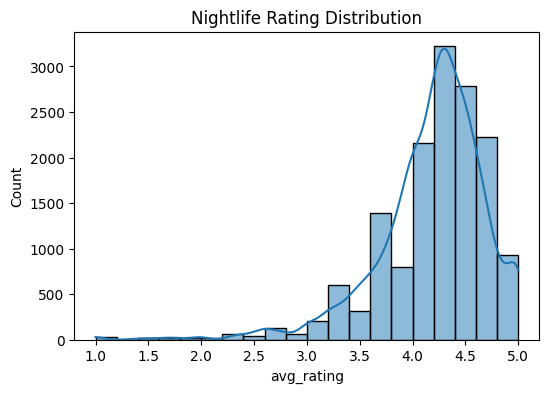

In [67]:
plt.figure(figsize=(6,4))
sns.histplot(night_rows["avg_rating"], bins=20, kde=True)
plt.title("Nightlife Rating Distribution")
plt.show()


c. Why "relative_results" are relative results? What features/categories connect them?

In [69]:
"0x535dcdd35d19b1:0xe92281e4cd46d74"


'0x535dcdd35d19b1:0xe92281e4cd46d74'

In [70]:
id_to_cat = dict(zip(df["gmap_id"], df["category"]))


In [73]:
#  dictionary: gmap_id → list of categories (or [])
id_to_cat = {}

for gid, cats in zip(df["gmap_id"], df["category"]):
    if isinstance(cats, list):
        id_to_cat[gid] = cats
    elif isinstance(cats, str):
        id_to_cat[gid] = [cats]
    else:
        id_to_cat[gid] = []


def category_overlap(row):
    """
 Calculates the average number of common categories between an object and its relative_results.
If there are no categories or no relative_results, 0
    """
    # base categories
    base_cats = row["category"]
    if isinstance(base_cats, list):
        base = set(base_cats)
    elif isinstance(base_cats, str):
        base = {base_cats}
    else:
        base = set()

    # relative_results —  id-шек
    rel_ids = row["relative_results"]
    if not isinstance(rel_ids, list) or len(rel_ids) == 0:
        return 0.0

    overlaps = []

    for rid in rel_ids:
        rel_cats = id_to_cat.get(rid, [])
        if isinstance(rel_cats, list):
            rel_set = set(rel_cats)
        elif isinstance(rel_cats, str):
            rel_set = {rel_cats}
        else:
            rel_set = set()

        overlaps.append(len(base & rel_set))

    if not overlaps:
        return 0.0

    return sum(overlaps) / len(overlaps)


In [74]:
df["cat_overlap"] = df.apply(category_overlap, axis=1)
df["cat_overlap"].describe()


,cat_overlap
count,21680.000000
mean,0.461185
std,0.585532
min,0.000000
25%,0.000000
50%,0.250000
75%,0.750000
max,5.600000


In [75]:
import numpy as np

#  dictionary id -> rating
id_to_rating = dict(zip(df["gmap_id"], df["avg_rating"]))

def avg_rel_rating(row):
    rel_ids = row["relative_results"]
    if not isinstance(rel_ids, list) or len(rel_ids) == 0:
        return np.nan

    ratings = []
    for rid in rel_ids:
        r = id_to_rating.get(rid)
        if r is not None:
            ratings.append(r)
    if len(ratings) == 0:
        return np.nan

    return sum(ratings) / len(ratings)

df["rel_avg_rating"] = df.apply(avg_rel_rating, axis=1)

# difference between the object's rating and the average relatives rating
df["rating_diff"] = (df["avg_rating"] - df["rel_avg_rating"]).abs()

df["rating_diff"].describe()


,rating_diff
count,17160.000000
mean,0.380913
std,0.423326
min,0.000000
25%,0.100000
50%,0.260000
75%,0.500000
max,4.000000


In [76]:
id_to_reviews = dict(zip(df["gmap_id"], df["num_of_reviews"]))

def avg_rel_reviews(row):
    rel_ids = row["relative_results"]
    if not isinstance(rel_ids, list) or len(rel_ids) == 0:
        return np.nan

    counts = []
    for rid in rel_ids:
        c = id_to_reviews.get(rid)
        if c is not None:
            counts.append(c)
    if len(counts) == 0:
        return np.nan

    return sum(counts) / len(counts)

df["rel_avg_reviews"] = df.apply(avg_rel_reviews, axis=1)
df["reviews_diff"] = (df["num_of_reviews"] - df["rel_avg_reviews"]).abs()

df["reviews_diff"].describe()


,reviews_diff
count,17160.000000
mean,114.555423
std,207.294841
min,0.000000
25%,15.000000
50%,48.000000
75%,129.000000
max,9730.000000


d. Find the top 5 closest point for each point using northing and easting?

In [77]:

from sklearn.neighbors import NearestNeighbors


In [80]:
# only lat/lon
coords_deg = df[["latitude", "longitude"]].to_numpy()    # shape (N, 2)


coords_rad = np.radians(coords_deg)

coords_rad.shape


(21680, 2)

In [81]:
# n_neighbors = 6:
nn = NearestNeighbors(
    n_neighbors=6,
    metric="haversine"
)

nn.fit(coords_rad)

# distances (in arc radians) and neighbor indices
dist_rad, ind = nn.kneighbors(coords_rad)

dist_rad.shape, ind.shape


((21680, 6), (21680, 6))

In [82]:
earth_radius_km = 6371.0
dist_km = dist_rad * earth_radius_km


In [83]:
rows = []

for i, (inds_row, dists_row) in enumerate(zip(ind, dist_km)):
    base_id = df.iloc[i]["gmap_id"]

    # inds_row[0] and dists_row[0] — (distance=0)
    for rank, (j, d) in enumerate(zip(inds_row[1:], dists_row[1:]), start=1):
        neighbor_id = df.iloc[j]["gmap_id"]

        rows.append({
            "gmap_id": base_id,
            "neighbor_rank": rank,       # 1..5
            "neighbor_id": neighbor_id,
            "distance_km": d
        })

neighbors_df = pd.DataFrame(rows)
neighbors_df.head(10)


,gmap_id,neighbor_rank,neighbor_id,distance_km
0,0x535dc557d042b1f3:0xc419b6f55435c7de,1,0x535dc557d042b1f3:0xc419b6f55435c7de,0.000000
1,0x535dc557d042b1f3:0xc419b6f55435c7de,2,0x535ddab3e143f7d5:0x9db429a96f02d43e,0.150344
2,0x535dc557d042b1f3:0xc419b6f55435c7de,3,0x535dc557c77ea0e7:0xba2708b5f00444ac,0.237494
3,0x535dc557d042b1f3:0xc419b6f55435c7de,4,0x535dc541c6f41073:0x848b2a8313138a9c,0.293879
4,0x535dc557d042b1f3:0xc419b6f55435c7de,5,0x535dcff87523a71d:0x4ab86c8240c83da8,0.341644
5,0x535c2690c357f3bd:0x272620bb52fecf11,1,0x535c2690c357f3bd:0x272620bb52fecf11,0.000000
6,0x535c2690c357f3bd:0x272620bb52fecf11,2,0x535c26dbc0942ebf:0xa5e602387358892f,2.414338
7,0x535c2690c357f3bd:0x272620bb52fecf11,3,0x535c26d5b3bce485:0x4f600fd455bc3ae6,3.088909
8,0x535c2690c357f3bd:0x272620bb52fecf11,4,0x535c2702a13ab209:0x236c9859435852fc,3.187801
9,0x535c2690c357f3bd:0x272620bb52fecf11,5,0x535c271baab2a3ef:0x6d87259634932785,3.819406


(BONUS) What kind of venues are usually close to each other?

In [88]:
cat_df = df[["gmap_id", "category"]].copy()

neighbors_with_cat = neighbors_df.merge(
    cat_df.rename(columns={"gmap_id": "neighbor_id", "category": "neighbor_category"}),
    on="neighbor_id",
    how="left"
)

neighbors_with_cat = neighbors_with_cat.merge(
    cat_df.rename(columns={"gmap_id": "gmap_id", "category": "base_category"}),
    on="gmap_id",
    how="left"
)


In [89]:
# Expand ALL category combinations:
# (each base category × each neighbor category)

pairs_long = (
    neighbors_with_cat
    .explode("base_category")
    .explode("neighbor_category")
)


pairs_long = pairs_long.dropna(subset=["base_category", "neighbor_category"])


In [90]:
pair_counts = (
    pairs_long
    .groupby(["base_category", "neighbor_category"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

pair_counts.head(20)


,base_category,neighbor_category,count
197203,Restaurant,Restaurant,685
205906,Service establishment,Service establishment,540
104300,Gas station,Gas station,525
40428,Campground,Campground,378
22250,Bar,Restaurant,342
196265,Restaurant,Bar,334
104636,Gas station,Restaurant,326
21487,Bar,Bar,325
196703,Restaurant,Gas station,304
231193,Tourist attraction,Tourist attraction,254


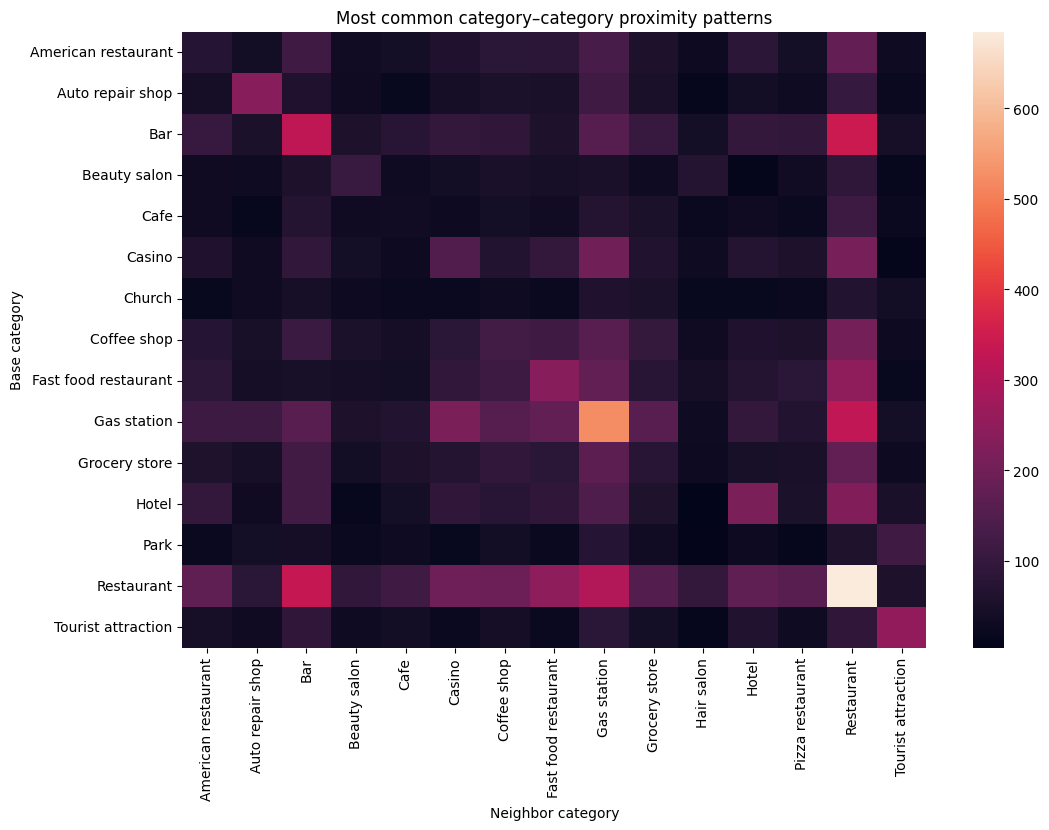

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

top_base = pair_counts["base_category"].value_counts().head(15).index
top_neigh = pair_counts["neighbor_category"].value_counts().head(15).index

pivot = pair_counts[
    pair_counts["base_category"].isin(top_base) &
    pair_counts["neighbor_category"].isin(top_neigh)
].pivot(
    index="base_category",
    columns="neighbor_category",
    values="count"
).fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=False)
plt.title("Most common category–category proximity patterns")
plt.xlabel("Neighbor category")
plt.ylabel("Base category")
plt.show()


Our analysis of the Montana Google Maps dataset reveals several clear structural patterns in how venues are geographically organized. By computing the 5-nearest neighbors for every location using geodesic (surface-based) distances and examining category-to-category co-occurrence frequencies, we observed that places tend to cluster into meaningful, functionally coherent groups.